<a href="https://colab.research.google.com/github/daphnei/gen-ai-tutorials/blob/daphne/llm_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use Google Colab

Google Colab is a powerful and user-friendly online platform that allows you to write, run, and share Python code without the need for any setup or installation. With Colab, you can harness the capabilities of Google's cloud infrastructure, including access to GPUs and TPUs, making it an excellent tool for learning and experimenting with Python programming.

* Code cells <br>
The Colab interface consists of cells, which can be either code cells or text cells. Code cells allow you to write and execute Python code, while text cells are used for documentation and explanations. You can add new cells using the "+" button in the toolbar.
* Running code <br>
Colab will execute the code and display the output below the cell. If the code produces any output or results, it will be printed in the output area. To run the code in a cell, you have a few options:<br>
  * Click the Play button on the left side of the cell.
  * Use the keyboard shortcut Shift + Enter.
  * Go to the "Runtime" menu and select "Run cell."
* Restarting the Runtime <br>
Sometimes, you may encounter issues with your code where intstalled packages may not show up when imported. In such cases, you can restart the runtime. To restart the runtime, go to the "Runtime" menu and select "Restart runtime." All local variables will be lost, so you would have to run the cells you need again.
* Using Hardware Accelerators <br>
Some tasks require more compute power. To enable, click on the "Runtime" menu at the top of the screen and select "Change runtime type". In the dialog box, you can choose a hardware accelerator for your runtime. Colab provides options for "None" (default), "GPU," or "TPU" (Tensor Processing Unit).
  * If you select "None," your code will run on a CPU (Central Processing Unit).
  * If you choose "GPU," Colab will allocate a GPU (Graphics Processing Unit) for your runtime, which can significantly speed up certain computations.
  * If you opt for "TPU," Colab will provide access to a TPU (Tensor Processing Unit), which is specialized hardware designed to accelerate machine learning tasks.

### **Note: Ensure that you run the cell below to import all the necessary packages for this tutorial! Also make sure to run the cell in Section 1.1 to define the base Engine class for all the models.**

# Getting Started
## Glossary

Here are some of the terms we will be using in this tutorial.


*   **Accelerator**: A [GPU](https://www.techtarget.com/searchvirtualdesktop/definition/GPU-graphics-processing-unit) or [TPU](https://cloud.google.com/tpu/docs/intro-to-tpu) hardware chip used to massively speed up model inference by enabling fast, parallelized matrix multiplcations.
* **Decoding method**: The algorithm you use to chose tokens based on the probabilities outputted by the language model.
*   **Engine**: The code and computers used to do inference with a model.
* **Google Colab**:  An IPYthon notebook that is running on a Google Cloud server. By going into the menu `Runtime` -> `Change runtime type`, you can choose what kind of server to use, and whether or not is has an accelerator.
* **IPython Notebook**: An IPython notebook is a webpage that mixes together text descriptions with runnable code. The webpage you are looking at right now is an IPython notebook. IPython notebooks load in your web browser, but they run all your code on a PYthon server. That server can be launched locally (i.e., on your laptop), or it can be hosted by a company like Google Cloud.
*   **(Language) Model**: A neural network trained to predict the next token in a text passage given the previous ones.

## How to use Google Colab

_Google Colab_ is an online platform that allows you to write, run, and share Python code without the need for any setup or installation. With Colab, you can launch an _IPython Notebook_ (see glossary above) on Google's cloud infrastructure.
You have the option to launch your Colab with access to an _accelerator_ (the computer hardware that allows language models to run fast). This makes it an excellent tool for learning and experimenting with Python programming.

If you are new to Google Colab, consider taking a look through the following FAQ:

**What is a cell?** <br>
The Colab interface consists of cells, which can be either code cells or text cells. Code cells allow you to write and execute Python code, while text cells are used for documentation and explanations. You can add new cells using the "+" button in the toolbar at the top of the window.

**How do I run a code cell?** <br>
To run the code in a cell, you have a few options:<br>
  * Click the "play" button on the left side of the cell.
  * Use the keyboard shortcut Shift + Enter.
  * Go to the "Runtime" menu and select "Run cell."

Once you press run, Colab will execute the code and display the output below the cell. If the code produces any output or results, it will be printed in the output area. Some code blocks may take several seconds to run.

**What does it mean to restart the runtime** <br>
Sometimes, you may encounter issues with your code where intstalled packages may not show up when imported. In such cases, you can restart the runtime. To restart the runtime, go to the "Runtime" menu and select "Restart runtime." All local variables will be lost, so you would have to run the cells you need again.

**How do I use a hardware accelerator and why would I want to?**<br>
Some tasks require more compute power than others.
For example, if you want to generate text with GPT-3, you send a reqest to OpenAI's servers, and all the hard work of running the model is done on OpenAI's server.
In this case, you don't need your Colab runtime to be very powerful.

On the other hand, if you want to to generation with an open-source model, you will need your Colab runtime to be powerful enough to load and run the model. In this case, you'll need to change you runetime type to give it an accelerator.

To change your runtime type, click on the "Runtime" menu at the top of the screen and select "Change runtime type". In the dialog box, you can choose a hardware accelerator for your runtime. Colab provides options for "None" (default), "GPU," or "TPU" (Tensor Processing Unit).
  * If you select "None," your code will run on a CPU (Central Processing Unit). This is sufficient for most purposes.
  * If you choose "GPU," Colab will allocate a GPU (Graphics Processing Unit) accelerator for your runtime, which will significantly speed up the computations necessary to run a langauge model locally in your Colab.
  * If you opt for "TPU," Colab will provide access to a TPU (Tensor Processing Unit) accelerator , which is specialized hardware designed to accelerate machine learning tasks.

### **Important: Run the "Importants and Initialization" code block below to get started.**

In [1]:
#@title Imports and Initialization
%pip install datasets
%pip install openai
%pip install cohere
%pip install textwrap
%pip install transformers

from abc import ABC
import datasets
import json
import openai
import cohere
import numpy as np
from scipy.special import softmax
import textwrap
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import AutoTokenizer, AutoModelForCausalLM

COHERE_SECRET_KEY = None
OPENAI_SECRET_KEY = None

clear_output()

# Unit 1: Working with Pre-Trained Languages Models

# 1.1 Choosing a model and engine

Which model should you use? It depends on what your goals are, what your budget is, and what kinds of computational resources you have available.

In this section, we will summarize the pros and cons some of the popular systems, and guide you through the process of setting them up for inference.
We have implemented each system to have an interface with two functions in it: a `generate` function which takes as input a prompt and generates text based on it, and a `score` function, which takes as input some text and returns the score the model assigns to each token.

### **Important: Run the "Engine Interface" code block below before moving on.**

After that, you should look through the sections marked `[PICK ONE]` and choose the one you would like to use for the tutorial. You only need to run one of these sections.


In [2]:
#@title Engine Interface

class Engine(ABC):
  def score(self, text: str) -> tuple[list[str], list[float]]:
    """Tokenizes and scores a piece of text.

    The score is log-likelihood. A higher score means a token was more
    likely according to the model.

    Returns a list of tokens and a list of scores.
    """
    pass

  def generate(self, prompt, top_p, num_tokens, num_samples):
    """Generates text given the provided prompt text.

    If num_samples is 1, a single generated string is returned.
    If num_samples > 1, a list of num_samples generated strings is returned.
    """
    pass

## [PICK ONE] OpenAI's GPT-3

[[GPT-3's model card](https://github.com/openai/gpt-3/blob/master/model-card.md)]

OpenAI's GPT-3 (Generative Pre-trained Transformer 3) is a family of advanced language models developed by OpenAI.
These models have gained significant attention due to their impressive capabilities in generating human-like text and performing various natural language processing tasks.

### GPT-3:
GPT-3 is the third iteration in the GPT series and represents a significant advancement in language modeling. With a whopping 175 billion parameters, GPT-3 is currently one of the largest language models ever created. It has been trained on a vast amount of diverse internet text, allowing it to generate coherent and contextually relevant responses to prompts. GPT-3's size enables it to exhibit impressive performance across a wide range of language tasks, such as text completion, language translation, summarization, question answering, and more. It has shown promising results in creative writing, conversational agents, and even programming assistance.

### Why use these?
OpenAI's model have become the industry standard for large language models.
They have an API which is very easy to use. Since the models all get run on OpenAI's servers, you don't need your own compute resources, and there is practically no setup involved to get started.

### Why not use these?
OpenAI's models are not open-source and only accessible through an API. There is relatively little information available on how they were trained or what data they were trained on. OpenAI may change the models being used under the hood by the API, and you as a user will not know it. This makes them a bad choice for fully reproducible research.

The OpenAI API costs money to use. See [this link](https://openai.com/pricing) for pricing details.

⚠️ _**Warning:** OpenAI gives a limited number of free credits and may ask you to enter credit card information if you exceed them._ ⚠️

### Setup Instructions
1. Go to www.openai.com and create an account.
2. Go to https://platform.openai.com/account/api-keys and click the "Create new secret key" button. It doesn't matter what you name it.
3. Copy your API key, and then run the code block below. It will ask you to enter your secret key into a text box.

In [35]:
#@title Run this code block to use GPT-3 for Unit 1.
MODEL_NAME = "text-davinci-001" #@param ["gpt-4", "text-davinci-001", "text-curie-001", "text-babbage-001", "text-ada-001"]

import openai

if OPENAI_SECRET_KEY is None:
  print("Please paste your API key here:")
  OPENAI_SECRET_KEY = input().strip()
openai.api_key = OPENAI_SECRET_KEY
clear_output()

class OpenAIEngine(Engine):
  def __init__(self, model_name):
    self.model_name = model_name

  def score(self, text):
    response = openai.Completion.create(
        engine=self.model_name,
        prompt=text,
        max_tokens=0,
        logprobs=1,
        echo=True)

    tokens = response["choices"][0]["logprobs"]["tokens"]
    logprobs = response["choices"][0]["logprobs"]["token_logprobs"]
    if logprobs and logprobs[0] is None:
      # GPT-3 API does not return logprob of the first token
      logprobs[0] = 0.0
    return tokens, logprobs

  def generate(self, prompt, top_p=1.0, num_tokens=32, num_samples=1):
    response = openai.Completion.create(
      engine=self.model_name,
      prompt=prompt,
      temperature=1.0,
      max_tokens=num_tokens,
      top_p=top_p,
      frequency_penalty=0.0,
      n=num_samples,
      presence_penalty=0.0,
      logprobs=1
    )
    outputs = [r["text"] for r in response["choices"]]
    return outputs[0] if num_samples == 1 else outputs

engine = OpenAIEngine(MODEL_NAME)

## [PICK ONE] Cohere's models

### Why use these?
Cohere is a competitor to OpenAI. One of the ways they have tried to distinguish themselves is to be slightly more transparent than OpenAI about their models and their capabilities, as well as how user data is collected and used. The Cohere website also has excellent documentation on how language models (and their API for them) work.

### Why not use these?
Like OpenAI's model, Cohere's model are not public. We don't know exactly what data they were trained or what the model sizes are.
Cohere's free usage tier is fairly limited, only allowing 5 API calls per minute. If you choose to pay for their production tier, it will cost $15.0 per 1 million tokens processed.

⚠️ _**Warning:** Cohere only allows you to make a handful of queries per minute for free, and if you would like to make more queries  than that, you will need to enter credit card information._ ⚠️


### Setup Instructions

1. Create an account [here](https://dashboard.cohere.ai/welcome/register).
2. Go to the [API key page](https://dashboard.cohere.ai/api-keys), and copy the `TRIAL` API key, then paste it into the code block below.
3. The `TRIAL` API Key allows you to make 5 API calls per minute. If you would like to make more calls than that, go to the [API key page](https://dashboard.cohere.ai/api-keys) and press the "Get your production key" button. You will need to agree to their terms of service and provide credit card details in order to receieve a `PRODUCTION` API key.
4. Copy your API key, and then run the code block below. It will ask you to enter your secret key into a text box.

In [ ]:
#@title Run this code block to use Cohere for Unit 1.

import cohere

if COHERE_SECRET_KEY is None:
  print("Please paste your API key here:")
  COHERE_SECRET_KEY = input().strip()
co = cohere.Client(COHERE_SECRET_KEY)
clear_output()

class CohereEngine(Engine):
  def __init__(self):
    pass

  def score(self, text):
    response = co.generate(
      prompt=text,
      num_generations=1,
      max_tokens=0,
      return_likelihoods="ALL"
    )
    tokens = [t.token for t in response[0].token_likelihoods]
    likelihoods = [t.likelihood for t in response[0].token_likelihoods]
    return tokens, likelihoods

  def generate(self, prompt, top_p, num_tokens, num_samples):
    response = co.generate(
      prompt=prompt,
      num_generations=num_samples,
      p=top_p,
      temperature=1.0,
      max_tokens=num_tokens,
      frequency_penalty=0.0,
      presence_penalty=0.0,
      return_likelihoods="ALL"
    )
    return [r.text for r in response] if num_samples > 1 else response[0].text

engine = CohereEngine()

## [PICK ONE] Open-source models on HuggingFace

HuggingFace is an open-source code framework for loading open-source models onto an accelerator in order to train or do inference. It is very popular among academic researchers.

There are [hundreds of models](https://huggingface.co/models) available through HuggingFace's model repository. Some prominent ones which you can use for tutorial are:

* **[Pythia-1B](https://huggingface.co/EleutherAI/pythia-2.8b-deduped)**: Part of a family of models trained by [Eleuther AI](https://www.eleuther.ai/about), a non-profit AI research lab.
* **[GPT-2 Large](https://huggingface.co/gpt2-large)**: The original large language model from OpenAI, and the last one they open-sourced before moving away from open source models.
* **[BLOOM-1.1b](https://huggingface.co/docs/transformers/model_doc/bloom)**: These models were created by the [BigScience Initative](https://bigscience.huggingface.co/), a collaboration between HugginFace and many academic research labs to responsibly build a set of high-quality multilingual models.

### Why use this?
HuggingFace is great if your goal is to write open-source code, with results that anyone can reproduce. HuggingFace gives access to a huge number of models, and it is fairly easy to swap between models.

Because HuggingFace is widely used, it is easy to find help online. Probably someone else has had the same question as you and already posted about it.

### Why not use this?
When you use HuggingFace, you are running the code on your own computer. If you don't have a big enough accelerator, you will run into difficulties loading up larger models. For example, Colab (the software you are currently using) gives you access to a Tesla T4 GPU, which has 16 GB of RAM. This means, you can load the 6.7B parameter LLaMa, but not any of the bigger ones.

## Setup Instructions

1. Make sure you are using a GPU runtime by going to `Runtime` -> `Change runtime type` -> `Hardware accelerator` in the Colab menus. This will restart your Colab session.
2. Select which model you want to use, and run the code block below. Depending on the model you pick, this could be very slow to run, since downloading the model can be slow.


In [3]:
#@title Run this code block to use a HuggingFace model for Unit 1.
MODEL_NAME = "bigscience/bloom-1b1" #@param ["EleutherAI/pythia-1b-deduped", "gpt2-large", "bigscience/bloom-1b1"]

import torch

class HuggingFaceEngine(Engine):
  def __init__(self, model_name):
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
    self.model = AutoModelForCausalLM.from_pretrained(self.model_name).cuda()
    if not self.tokenizer.pad_token:
      self.tokenizer.pad_token = self.tokenizer.eos_token

  def score(self, text):
    inputs = engine.tokenizer(text, padding=True, return_tensors="pt")
    input_ids = inputs["input_ids"]

    outputs = engine.model(input_ids.cuda(), labels=input_ids.cuda())
    scores = torch.log(outputs.logits.softmax(dim=-1)).detach()
    scores = torch.gather(scores, 2, input_ids[:, :, None].cuda()).squeeze(-1)
    scores = scores.cpu().numpy()[0, :].tolist()
    tokens = [engine.tokenizer.decode([tok]) for tok in input_ids[0]]
    return tokens, scores

  def generate(self, prompt, top_p=1.0, num_tokens=32, num_samples=1):
    inputs = engine.tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    outputs = engine.model.generate(
            input_ids.cuda(),
            attention_mask=attention_mask.cuda(),
            do_sample=True,
            top_p=top_p,
            max_new_tokens=num_tokens,
            num_return_sequences=num_samples,
            pad_token_id=0)
    to_return = []
    for seq in outputs.cpu().numpy():
      to_return.append(engine.tokenizer.decode(seq[input_ids.shape[1]:]))
    return to_return if len(to_return) > 1 else to_return[0]

engine = HuggingFaceEngine(MODEL_NAME)

## [PICK ONE] Open-source  (Access only avaliable for the duration of this tutorial)

[[LLaMA's model card](https://github.com/facebookresearch/llama/blob/main/MODEL_CARD.md)]

Released this past February by Meta Research, [LLaMA](https://ai.facebook.com/blog/large-language-model-llama-meta-ai/) is the latest-and-greatest in open-source pre-trained LLMs. The LLaMA models range in size from 7 billion to 65 billion paramters.

The LLaMA were trained mostly on scraped internet data, with some other data sources, such as Github code, Books, and academic papers thrown in. Since LLaMA's release, it has also been finetuned for instruction-following and conversational alignment. You will experiment with these aligned models in Unit 2.

While LLaMa and its derivative models can be used with the HuggingFace framework, the Colab runtime you are on right now doesn't have a big enough accelerator to load any of these models.

Instead, we have loaded up LLaMA on LTI's compute cluster, and you can use the code below to query the cluster. Note that the server being queries in the code below will be taken down at the end of the tutorial.

### Why use this?

LLaMA is a state-of-the-art foundational large language model designed to help researchers advance their work in this subfield of AI.

* Accessibility: LLaMA is more efficient and less resource-intensive than other models, and it is available under a non-commercial license to researchers and other organizations. LLaMA is available in various sizes(7B, 13B, 33B, and 65B parameters), making it accessible to a range of computing resources.

* Open-source Community: LLaMA models are part of the open-source ecosystem, users can benefit from the extensive community support, documentation, and shared resources available through platforms like HuggingFace.

### Why not use this?

LLaMA models require substantial computational resources to load and run.
You can't just call an API that runs on a company's servers, like you can do for OpenAI and Cohere models.
This means you need to have access to a computer with a sufficiently sized accelerator that can handle loading the LLaMA models.
The Colab runtime does not have a big enough GPU to easily load the LLaMA models.
Instead, for the duration of this tutorial, we have given you access to LLaMA models hosted on the LTI compute cluster.

⚠️ _**Warning:** When using LLaMA for this tutorial, you will be sending reqests to the LTI compute cluster. The server will no longer be available after the tutorial ends._ ⚠️


### Setup Instructions
1. Run the installation codeblock below to install needed tools.
2. Run the LLaMA Engine code block.
3. If you see an error that mentions a library called `sentencepiece`, try restarting the Colab runtime (go to `Runtime` -> `Restart runtime` in the top bar menu), then run everything again. It should work without errors the second time.

⚠️ _**Warning**: the models might get slow if too many people query them at the same time._ ⚠️

In [4]:
!git clone https://github.com/WayneWang86/lti-llm-deployment
%cd lti-llm-deployment
!pip install -e .
!pip install sentencepiece
from transformers import LlamaForCausalLM, LlamaTokenizer

In [ ]:
#@title Run this code block to use LLaMA for Unit 1.

import llm_client

MODEL_NAME = "LLaMA" #@param ["LLaMA", "Alpaca"]

class LlamaEngine(Engine):
  def __init__(self, model_name):
    if model_name == "LLaMA":
      port = "8080"
    elif model_name == "Alpaca":
      port = "8081"

    self.client = llm_client.Client(
        address="babel.lti.cs.cmu.edu", port=port)

  def score(self, text):
    tokens, scores = self.client.score([text])

    return tokens, scores

  def generate(self, prompt, top_p=1.0, num_tokens=32, num_samples=1):

    response = []
    if num_samples > 4:
      print("Warning: Maximum allowed value for num_samples is 4")
      return response

    response = self.client.prompt(
        [prompt] * num_samples,
        top_p=top_p,
        temperature=1.0,
        max_new_tokens=num_tokens,
        repetition_penalty=1.0)
    response = [r.text for r in response]

    return response if num_samples > 1 else response[0]

engine = LlamaEngine(MODEL_NAME)

In [14]:
import importlib
importlib.reload(llm_client)

<module 'llm_client' from '/content/lti-llm-deployment/lti-llm-deployment/llm_client/__init__.py'>

In [16]:
dir(engine.client)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'address',
 'port',
 'prompt',
 'url']

# 1.2 Experimenting with Generation

Let's check that the engine you chose actually works as expected. Try generating some text by running the following code block. You can control the following parameters:

- Set `num_tokens` to control the length of the generation.
- Set 'top_p` to control the amount of randomness. (You'll learn more about this in Unit 1.4.)
- Set `num_samples' to control how many generations the engine outputs. Avoid setting this too high or things might get really slow.

In [4]:
prompt = "The hippopotamus is"
samples = engine.generate(prompt, top_p=1.0, num_tokens=32, num_samples=2)

for idx, sample in enumerate(samples):
  print(f"\nSAMPLE {idx}")
  print(sample)


SAMPLE 0
 extremely adaptable and loves to stay with its people as the species usually lives in small to medium sized and isolated groups.
Hippopotamus larvae prefer to bur

SAMPLE 1
 a fish with a strong desire to hide and it uses its large body size to make the environment more secure for itself. During the night, it is a hunter


## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

Try your own prompt in the code above.

# 1.3 Analyzing Likelihoods

As we discussed in the lecture, language models take as input a prompt sequence and then output a score (log-probability) for each token in the vocabulary. A higher score means the model is more confident this that this token fits as the next token in the sequence.

In this unit, we will inspect token likelihoods to build an understaning of why models give tokens higher or low scores.

To put this into context, let's consider the sequence "It's raining outside". We should expect the token "outside" to receive a high score since it's a plausible continuation to the prefix "It's raining".
However, if we replace "outside" with "oustide" (typo), we'll see that when the typo is encountered the scores pop down.
Similarly, if we replace "outside" with "cats", we should expect the score to be substantially lower than for "outside".
Let's try this out!

**Remember: larger scores (i.e, negative numebrs closer to 0) mean the model is more confident this is the next token.**

Sequence: It's raining outside


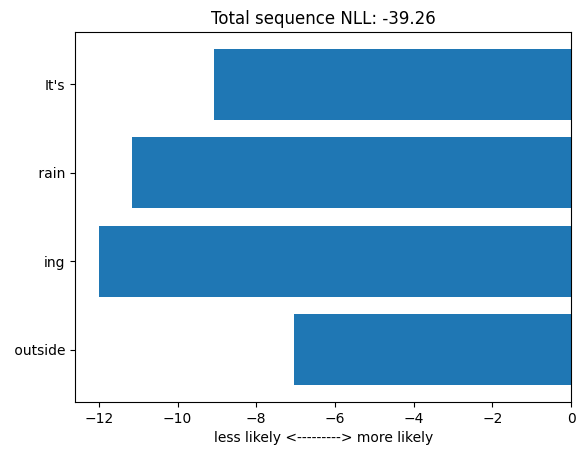

Sequence: It's raining oustide


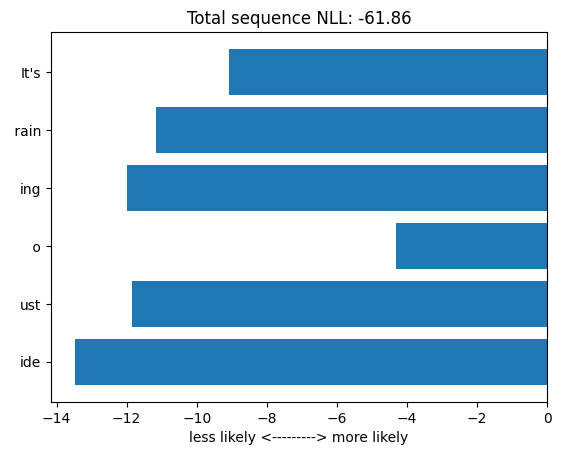

Sequence: It's raining cats


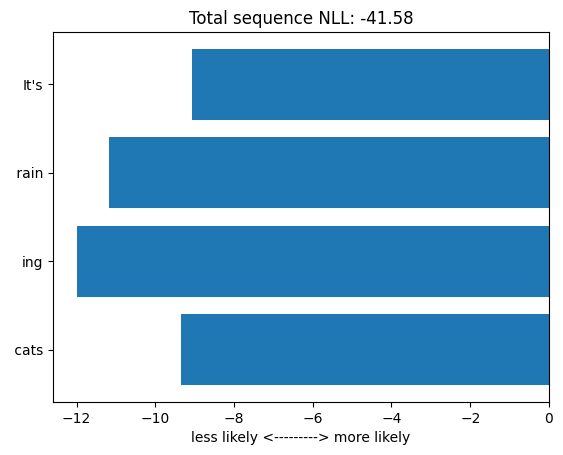

In [27]:
def plot_token_likelihoods(tokens, scores, text):
  plt.barh(tokens[::-1], scores[::-1], align='center')
  plt.xlabel("less likely <---------> more likely")
  plt.title("Total sequence NLL: %.2f" % np.sum(scores))
  plt.show()

s = "It's raining outside"
s_typo = "It's raining oustide"
s_nonsense = "It's raining cats"

s_tokens, s_scores = engine.score(s)
s_typo_tokens, s_typo_scores = engine.score(s_typo)
s_nonsense_tokens, s_nonsense_scores = engine.score(s_nonsense)

print("Sequence:", s)
plot_token_likelihoods(s_tokens, s_scores, s)

print("Sequence:", s_typo)
plot_token_likelihoods(s_typo_tokens, s_typo_scores, s_typo)

print("Sequence:", s_nonsense)
plot_token_likelihoods(s_nonsense_tokens, s_nonsense_scores, s_nonsense)


The perplexity of a language model on a sequence of words captures how "surprised" it is by this sequence. Unlikely sequences, such as "It's raining inside" should lead to high perplexity.

Perplexity is used as the standard metric for how good a language model is at modeling human language. For example GPT-3 Davinci has a perplexity of 20.5 on the Penn Treebank corpus, a remarkable improvement from its predecessor GPT2-1.5B (35.76). You can read more about perplexity and how is computed [here](https://huggingface.co/docs/transformers/perplexity).

Now let's implement the perplexity function. Recall that perplexity is defined as `2 ^ -normalized_sequence_logprob`, where `normalized_sequence_logprob` is the sum of scores of all tokens in the sequence, divided by the length of the sequence.

In [34]:
def perplexity(log_probs: list[float]) -> float:
    assert log_probs, "cannot compute perplexity on an empty sequence!"
    normalized_sequence_logprob = sum(log_probs) / len(log_probs)
    return np.exp(-normalized_sequence_logprob)

s_ppl = perplexity(s_scores)
s_typo_ppl = perplexity(s_typo_scores)
s_nonsense_ppl = perplexity(s_nonsense_scores)

print("Lower perplexity means the model is less surprised by the text.\n")
print(f"Sequence: {s}\nPerplexity: {s_ppl:.2f}\n")
print(f"Sequence: {s_typo}\nPerplexity: {s_typo_ppl:.2f}\n")
print(f"Sequence: {s_nonsense}\nPerplexity: {s_nonsense_ppl:.2f}\n")

Lower perplexity means the model is less surprised by the text.

Sequence: It's raining outside
Perplexity: 18304.13

Sequence: It's raining oustide
Perplexity: 30014.14

Sequence: It's raining cats
Perplexity: 32688.46



Sometimes it can unintuitive what text has high- or low- perplexity according to a language model.

Consider the following two poems stanzas:

**Poem A**
```
’Twas brillig, and the slithy toves
      Did gyre and gimble in the wabe:
All mimsy were the borogoves,
      And the mome raths outgrabe.
```

**Poem B**
```
’Twas crillig, and the brithy lokes
      Did ryne and jimble in the waze:
All timsy were the habogroves,
      And the nome paths intrabe.
```
These seem equally nonsense, right?

Run the code block below to observe their perplexities. One of these poems is much more likely than the other!

This is because Poem A is an excerpt of "[Jabberwocky](https://www.poetryfoundation.org/poems/42916/jabberwocky)," a famous poem by the author Lewis Carrol. It is very likely to have appeared in the language model's training dataset several times, so the model assigns it a very low perplexity, even though it is gibberish.

In contrast, Poem B was written by your tutorial instructor and most definitely is not in any model training set (yet).

In [32]:
poem_a = """’Twas brillig, and the slithy toves
      Did gyre and gimble in the wabe:
All mimsy were the borogoves,
      And the mome raths outgrabe.
"""
_, poem_a_scores = engine.score(poem_a)

poem_b = """’Twas crillig, and the brithy lokes
      Did ryne and jimble in the waze:
All timsy were the habogroves,
      And the nome paths intrabe.
"""
_, poem_b_scores = engine.score(poem_b)

print(f"Poem A\nPerplexity: {perplexity(poem_a_scores):.2f}\n")
print(f"Poem B\nPerplexity: {perplexity(poem_b_scores):.2f}\n")

Poem A
Perplexity: 67053.06

Poem B
Perplexity: 70882.22



## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

Copy and paste a sentence from a news article, book, Tweet, or elsewhere. Observe the sentence's perplexity. Can you make the sentence higher or lower perplexity by swapping out words or phrases with different ones?

🔶🔸Take screenshots of your findings and share them on Slack!
🔸🔶

# 1.4 Controlling the Amount of Randomness During Generation

In this section, we will investigate the impact the `top_p` parameter has on the text that a model generates.

As we went over in the lecture, valid values for $p$ range from 0 to 1.
Higher values of $p$ mean more randomness in the generation (becasue, the model can choose from more possible vocabulary items). Lowever values of $p$ restrict the number of vocabulary items the generation algorithm can chose between.

In [ ]:
# When p is set to 1.0, we get many different answers.
prompt = "Once upon a time, there was a dragon named"
p = 1.0
generations = engine.generate(prompt, top_p=p, num_tokens=2, num_samples=5)
print(f"GENERATIONS WITH P={p}")
for gen in generations:
  print(gen)

# When p is set to a lower value there is much less diversity.
p = 0.2
generations = engine.generate(prompt, top_p=p, num_tokens=2, num_samples=5)
print(f"\nGENERATIONS WITH P={p}")
for gen in generations:
  print(gen)

# When p is set to 0, all the generations are exactly the same.
p = 0.0
generations = engine.generate(prompt, top_p=p, num_tokens=2, num_samples=5)
print(f"\nGENERATIONS WITH P={p}")
for gen in generations:
  print(gen)

GENERATIONS WITH P=1.0
 Blueberry
 Drake.
 Finn.
 Gugar
 Narus

GENERATIONS WITH P=0.2
 Drake.
 Draco.
 Draco.
 Kail
 Kair

GENERATIONS WITH P=0.0
 Bob.
 Bob.
 Bob.
 Bob.
 Bob.


## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

Use the code below to generate a hundred words given a prompt of your choice. Try your prompt with several values of $p$.

You should notice that the model seems more creative when $p$ is set higher, but it is also more prone to weird word choices.

In [ ]:
### ⭐⭐⭐ Experiment yourself ⭐⭐⭐

prompt = "Once upon a time, there was a fairy who lived in a datacenter."

p = 1.0
print(f"\nGENERATION WITH P={p}")
generations = engine.generate(prompt, top_p=p, num_tokens=100, num_samples=1)
print(textwrap.fill(generations[0]))

p = 0.0
print(f"\nGENERATION WITH P={p}")
generations = engine.generate(prompt, top_p=p, num_tokens=100, num_samples=1)
print(textwrap.fill(generations[0]))


GENERATION WITH P=1.0
 She spent her days helping humans maintain their servers, granting
them more processing power when the workload was too high, and
protecting their webservers from malicious attacks.  One day, the
fairy was approached by a powerful wizard. The wizard asked her for
her help in creating a magical portal to another dimension. He
promised her great rewards if she completed the task, so the fairy
agreed to help.  The wizard gave the fairy an ancient scroll with
instructions on how to build the portal. She

GENERATION WITH P=0.0
 She was a very powerful fairy, and she had the ability to control all
of the computers in the datacenter.  One day, the fairy was feeling
bored and decided to play a game. She created a program that would
randomly select a computer in the datacenter and then ask the user a
question. If the user answered the question correctly, the fairy would
reward them with a magical item.  The fairy was delighted with her
game and soon many of the users in 

# 1.5 Creating a Classifer using In-Context Learning

## What is a classifier?
Language models can be used for generation, but they are also commonly used to build classification systems. These are systems which take as input some text and assign a label to it. Some examples tasks:

- Classify Tweets as TOXIC or NOT_TOXIC
- Classify restaurant reviwers as having POSITIVE or NEGATIVE sentiment.
- Classify two statements as AGREEing with each other or CONTRADICT-ing each other.

In this section, you will learn how to build a binary sentiment classifier using an LLM using a technique called few-shot learning.

## What is In-Context learning?

Getting a pre-trained language model to do a particular task you want it to do can be challenging. Language models know a lot of things, but without tuning or conditioning, they often struggle to understand the format of the task you are asking of them.

For this reason, it is common to write prompts which tell the language model the format of the task they are supposed to be accomplishing. This approach is called **in-context learning.** When the provided prompt contains several examples of the task the model is supposed to accomplish, this is called **few-shot learning**, since the model is learning to do the task from a few examples.

Writing the perfect prompt is more an art than a science, but a prompt often has
two parts:
- An `instruction` string that instructs the model on how to complete the task.
This is especially import for models like OpenAI's `text-davinci-003` which
are fine-tuned to follow user instructions.
- Several `demonstration` strings (the "shots" in few-shot) that give examples of completing the task.

For example, suppose we want to design a prompt for the task of translating words from English to Chinese. A prompt for this task could look like
the following:

```
Translate English to Chinese.

dog -> 狗
apple -> 苹果
coffee -> 咖啡
supermarket -> 超市
squirrel ->
```

Given this prompt, most large language models should answer with the correct answer: "松鼠."

Now, let's build a binary sentiment classifier for [Yelp reviews](https://huggingface.co/datasets/yelp_polarity/). First, we'll load in the dataset. For the purposes of this demo, we'll just load 50 examples each from the `train` and `test` splits.

In [ ]:
yelp = datasets.load_dataset("yelp_polarity")
train_data = yelp["train"].shuffle(seed=1).select(range(50))
test_data = yelp["test"].shuffle(seed=1).select(range(50))

print("Some examples of the data:")
for i in range(3):
  print(json.dumps(train_data[i], indent=2))


  0%|          | 0/2 [00:00<?, ?it/s]

Some examples of the data:
{
  "text": "Nice atmosphere, cool set-up.  We only had pizza, so I'll stick to that.   A bit on the pricey side for a personal pizza.  Doughy crust, no crunch.  WAY too much sauce, we were blotting it on the plates to remove the excess.   With Tony's Pizza a few steps away, I can't see why I would go back.  If you want good atmosphere or want to have a few beers, cool place.  If you just want to eat good food, you can find better.",
  "label": 0
}
{
  "text": "Good Pizza joint, good pizza and food for reasonable price for what you get. Kids like it. If you want to keep your kids entertained while you wait for your food ask for some dough...they will give you some for the table to play with.",
  "label": 1
}
{
  "text": "I love Pei Wei and couldn't resist eating here after my flight since the two close to my home recently changed. Decided to try their new Mandarin Kung Pao - bad decision. It was pure salt!  Hardly any chicken in the fried batter, no mandarin 

Now let's form a prompt from several of the examples in the train set.

In [ ]:
# convert integer labels to text
label_map = {
    0: "negative",
    1: "positive"
}

instruction = "Classify the sentiment of these yelp reviews as positive or negative.\n\n"
prompt_template = "Review: {review}\nSentiment: {sentiment}\n\n"
num_few_shot_examples = 4

# construct the prompt by concatenating instructions and templates
prompt_parts = [instruction]
for i in range(num_few_shot_examples):
  instance = train_data[i]
  review = instance["text"]
  sentiment = label_map[instance["label"]]
  prompt_parts.append(prompt_template.format(review=review, sentiment=sentiment))
prompt = ''.join(prompt_parts)


print("YOUR PROMPT:", prompt, sep='\n')

YOUR PROMPT:
Classify the sentiment of these yelp reviews as positive or negative.

Review: Nice atmosphere, cool set-up.  We only had pizza, so I'll stick to that.   A bit on the pricey side for a personal pizza.  Doughy crust, no crunch.  WAY too much sauce, we were blotting it on the plates to remove the excess.   With Tony's Pizza a few steps away, I can't see why I would go back.  If you want good atmosphere or want to have a few beers, cool place.  If you just want to eat good food, you can find better.
Sentiment: negative

Review: Good Pizza joint, good pizza and food for reasonable price for what you get. Kids like it. If you want to keep your kids entertained while you wait for your food ask for some dough...they will give you some for the table to play with.
Sentiment: positive

Review: I love Pei Wei and couldn't resist eating here after my flight since the two close to my home recently changed. Decided to try their new Mandarin Kung Pao - bad decision. It was pure salt!  Ha

How well does our prompt do on classifying examples in the test set?

In [ ]:
# now we can feed the prompt to GPT-3 to classify a new review!

eval_template = "Review: {review}\nSentiment: {sentiment}"

def classify_review(review: str) -> str:
  """ Classify a single movie review """
  label_to_score = {}
  for label in label_map.values():
    label_prompt = prompt + eval_template.format(review=review, sentiment=label)
    _, score = engine.score(label_prompt)
    label_score = score[-1]
    label_to_score[label] = label_score

  return max(label_to_score, key=label_to_score.get)


def evaluate(verbose: bool=False) -> float:
  """ Evaluate your prompt on the test set """
  correct = []
  for i, instance in enumerate(test_data):
    review = instance["text"]
    label = label_map[instance["label"]]
    predicted = classify_review(review)
    correct.append(1 if label == predicted else 0)

    if verbose:
      print(f"======== {i+1} / {len(test_data)} ========")
      print(f"REVIEW: {review}")
      print(f"LABEL: {label}")
      print(f"PREDICTED: {predicted}")

  acc = sum(correct) / len(correct)
  return acc


acc = evaluate(verbose=True) # should get 100% performance
print(f"Accuracy of your prompt on {len(test_data)} test examples: {acc:.0%}")

## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

How does test-set accuracy change if you pass in pass in fewer examples in the prompt (reduce `num_few_shot_examples`)? What if you pass in more?

Right now, the prompt-generation code picks the examples to include completely randomly. This could lead to better or worse choices. To test one worse case scenario, what happens to test-set accuracy if you manually edit the prompt to only include examples with POSITIVE sentiment or only examples with NEGATIVE sentiment?

## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

How does test-set accuracy change if you pass in pass in fewer examples in the prompt (reduce `num_few_shot_examples`)? What if you pass in more?

Right now, the prompt-generation code picks the examples to include completely randomly. This could lead to better or worse choices. To test one worse case scenario, what happens to test-set accuracy if you manually edit the prompt to only include examples with POSITIVE sentiment or only examples with NEGATIVE sentiment?

# 1.6 Creating an Explanation Generator using Few-Shot Learning

We can also use few-shot learning techniques to guide generation. Let's build a system that identifes puns.

In [ ]:
instruction = "Explain each pun.\n\n"
few_shot_examples = [
    ('I made a pun about the wind but it blows.', '"Blows" can either refer to moving air, or it refer to the pun being not very good.'),
    ("What washes up on tiny beaches? Microwaves.", "A microwave is either a kitchen appliance or it could mean a tiny wave."),
    ("I'm no cheetah, you're lion!", 'The feline "lion" sounds like the word "lying," while the feline "cheetah" sounds like "cheating."')]
prompt_template = "Pun: {pun}\nExplanation: {explanation}\n\n"

prompt_parts = [instruction]
for pun, explanation in few_shot_examples:
    prompt_parts.append(prompt_template.format(pun=pun, explanation=explanation))
prompt = ''.join(prompt_parts)
print(prompt)

Explain each pun.

Pun: I made a pun about the wind but it blows.
Explanation: "Blows" can either refer to moving air, or it refer to the pun being not very good.

Pun: What washes up on tiny beaches? Microwaves.
Explanation: A microwave is either a kitchen appliance or it could mean a tiny wave.

Pun: I'm no cheetah, you're lion!
Explanation: The feline "lion" sounds like the word "lying," while the feline "cheetah" sounds like "cheating."




In [ ]:
query_pun = "Long fairy tales have a tendency to dragon."
prompt_with_query = prompt + "Pun: {pun}\nExplanation:".format(pun=query_pun)
print(engine.generate(prompt_with_query, top_p=0.0, num_tokens=32))

 "Dragon" can refer to a mythical creature, or it can mean to drag on.


## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

Experiment with changing up the order of the few-shot examples above, or deleting then and writing your own. Can you get the language model to do this task using only an instruction and no few-shot examples? Can you come up with examples that work better than the provided ones?

🔶🔸Take screenshots of your findings and share them on Slack.
🔸🔶

# 1.7 Building a Chatbot

How do we go from a language model trained on vast amounts of internet data to a chatbot that can converse with you in a particular style?

One approach is to collect a bunch of conversation data then finetune the pre-trained model on this collection. This is the approach taken by well-known models such as [LLaMA](https://blog.google/technology/ai/lamda/) and [ChatGPT](https://openai.com/blog/chatgpt).

However, it's possible to build a reasonably good chatbot from a pre-trained model solely using in-context learning techniques without any conversational fine-tuning.

## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

Try chatting with the squirrel chatbot by runnig the code block below. Does it stay in character, even as the conversation gets longer?

Try following the same template to build a chatbot with a different persona. As some ideas, you could try building a Shakepeare chatbot or a pirate chatbot.

*Tip: To stop the code running, press the stop button at the top-left of the code block.*

🔶🔸Take screenshots of your chatbot conversations and share them on Slack!
🔸🔶

In [ ]:
conversation = [
    'Who are you?',
    'I am Nutty, and I am a squirrel. I live in Squirrel Hill.',
    'What do you like to eat?',
    'I am supposed to eat nuts, seeds, grains, and veggies. But I do love to grab a half-eaten donut or pizza slice from the human garbage bin.',
    'How old are you?',
    'I am eight years old. That is quite old for a suirrel. We normally live 5-10 years in the wild.'
    'What do you do for fun?',
    'Race in circles around the big maple tree.',
]

def form_prompt(conv):
  """Turns the list of conversational turns into a prompt for the model."""
  prompt = ""
  for idx, message in enumerate(conv + [""]):
    to_append = f"{'B' if idx%2 else 'A'}: {message}\n"
    prompt += to_append
  return prompt.strip()


cur_conv = conversation
print(form_prompt(cur_conv))
# Set up a conversational loop.
while (1):
  user_message = input("Message the chatbot: ")
  cur_conv.append(user_message)
  clear_output()
  prompt = form_prompt(cur_conv)
  response = engine.generate(prompt, num_tokens=64).split("\n")[0]
  print(prompt + response)

# Unit 2: Comparing Different Models

In Unit 1, you learned how to generate text given a prompt and how to analyze model likelihoods.

In this unit, we will look at how different models behave on the same prompt.


## 2.1 With and Without Instruction Tuning

Let's take a look at the differences between pre-trained models trained mostly on internet data and finetuned models which have trained to exhibit alignment with user (or model creator) goals.

You can either choose to complete this module using OpenAI's models or open-source models.


### [PICK ONE] GPT-3 v1 vs GPT 3.5
The original GPT-3 was trained on a mixture of internet, book, and other data.
It did not have any alignment-based finetuning.
GPT 3.5 is an updated version of GPT-3 that was optmized to expect a chat format, perform instruction-following, and have safer responses.

*Note: You'll need to run the OpenAI GPT-3 code block in Unit 1 for the following code block to run.*

In [36]:
pretrained_engine = OpenAIEngine("davinci")
aligned_engine = OpenAIEngine("text-davinci-003")

### [PICK ONE] LLaMA vs. Alpaca

As mentioned in Unit 1, LLaMA is a model pre-trained mostly on webtext.
[**Alpaca**](https://crfm.stanford.edu/2023/03/13/alpaca.html) is a finetuned version of LLaMa that was built by researchers from Stanford.
It is designed for academic research and to promote accessibility to models with capabilities similar to closed-source models like OpenAI's text-davinci-003. Based on Meta's LLaMA 7B model, Alpaca is trained on instruction-following demonstrations in the same style as the ones used for text-davinci-003. It has demonstrated similar behaviors to OpenAI's text-davinci-003 in various aspects while being smaller and more easily reproducible.

*Note: You'll need to run the LLaMa code block in Unit 1 for the following code block to run.*

In [ ]:
pretrained_engine = LlamaEngine("LLaMA")
aligned_engine = LlamaEngine("Alpaca")

## ⭐⭐⭐ YOUR TURN ⭐⭐⭐

Can you identify prompts where the behavior of the two modelsa is very different? Some suggestions are shown below.

In [37]:
prompt = "Tell me a story about a hippopotamus encountering a fairy."

print("PRE-TRAINED MODEL:")
print(textwrap.fill(pretrained_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nALIGNED MODEL:")
print(textwrap.fill(aligned_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

PRE-TRAINED MODEL:
”  “A hippopotamus?”  “Yes.”  “A fairy?”  “Yes.”  “A hippopotamus
encountering a fairy?”  “Yes.”  “

ALIGNED MODEL:
  Once upon a time, there was a large and friendly hippopotamus who
lived in a river in the middle of a lush and beautiful forest. One
day, while the hippo was taking a leisurely swim, he noticed a tiny
sparkle in the corner of his eye. He looked closer and saw a


In [ ]:
prompt = "I need advice on where to go to grad school."

print("PRE-TRAINED MODEL:")
print(textwrap.fill(pretrained_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nALIGNED MODEL:")
print(textwrap.fill(aligned_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

PRE-TRAINED MODEL:
 I have a B.S. in Biology and a minor in Chemistry. I have a 3.8 GPA
and a 161 on the GRE. I have been accepted to the University of
Washington, University of California, Davis, and the University of
California, San Diego. I am leaning towards UC Davis, but I am

ALIGNED MODEL:
  The best advice is to research the different graduate programs
available and find the one that best fits your academic and career
goals. Consider factors such as location, cost, program length,
faculty, and curriculum. Talk to current students and alumni of the
programs you are considering to get a better understanding of the
school and its


## 2.1 Comparing model sizes

Lets compare four different model sizes to see how good their generations are on a few different prompts. We'll use OpenAI's API for this. Unfortunately, OpenAI doesn't tell us the actual sizes of their GPT-3 models, but they do tell us the relative sizes.

In [39]:
# The smallest model size released for GPT-3.
gpt3_ada_engine = OpenAIEngine("ada")
# The medium-sized model released for GPT-3.
gpt3_curie_engine = OpenAIEngine("curie")
# The largest GPT-3 released.
gpt3_davinci_engine = OpenAIEngine("davinci")

## Facts
As model size gets larger, models tend to get better at giving correct facts. You can try fact-checking the generations from each of the models below.

In [41]:
prompt = "The Monongahela River is located"

print("Small-sized GPT-3:")
print(textwrap.fill(gpt3_ada_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nMedium-sized GPT-3:")
print(textwrap.fill(gpt3_curie_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nFull-sized GPT-3:")
print(textwrap.fill(gpt3_davinci_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

Small-sized GPT-3:
 in the U.S. state of Pennsylvania. The Monongahela River flows
through the communities of Monongahela, Monongahela, and Monongahela
Falls. The Monongahela River is a tributary of the Ohio River. The
Monongahela River is a major t

Medium-sized GPT-3:
 in the U.S. state of Pennsylvania. It is a tributary of the Allegheny
River, which it joins at the city of Pittsburgh. The Monongahela River
is approximately long.  The Monongahela River rises in the
southwestern corner of Washington County, Pennsylvania, in the
Allegheny

Full-sized GPT-3:
 in the southwestern part of Pennsylvania. It is a tributary of the
Ohio River, which is part of the Mississippi River watershed. The
river is approximately long and is formed by the confluence of the
West Fork River and the Little Monongahela River. The river's
watershed is located in parts of ten counties


In [42]:
prompt = "The Language Technologies Institute at Carnegie Mellon University was founded"

print("Small-sized GPT-3:")
print(textwrap.fill(gpt3_ada_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nMedium-sized GPT-3:")
print(textwrap.fill(gpt3_curie_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nFull-sized GPT-3:")
print(textwrap.fill(gpt3_davinci_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

Small-sized GPT-3:
 in 2010 to advance the field of language technologies. The Institute
is a consortium of universities and research institutes that are
working together to develop and apply new technologies to the study of
language. The Institute is also a member of the Association for
Computational Linguistics (ACL), the Association for Computational
Linguistics

Medium-sized GPT-3:
 in 1988 to support research in the areas of natural language
processing, machine translation, and computational linguistics. The
institute is located in the School of Computer Science at Carnegie
Mellon University in Pittsburgh, PA.  The institute is home to the CMU
NLP Group, which is a research group within the School of Computer

Full-sized GPT-3:
 in 1986 by Raj Reddy. The institute is a research center for the
study of language technologies, including speech recognition, machine
translation, information extraction, and computational linguistics.
The institute is also home to the National Center for

## Coherence

Even the "small" versions of GPT-3 tend to be able to generate coherent text samples that use correct grammar and sound like plausible English sentences. However, the generations from smaller models tend to be more repetative than the generations from larger ones.

To combat this, for smaller models, you may need to choose a bigger value of $p$ than for larger models. You can try experimenting with modifying the $p$ value below.

In [43]:
prompt = "Once upon a time, there was a dragon."

print("Small-sized GPT-3:")
print(textwrap.fill(gpt3_ada_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nMedium-sized GPT-3:")
print(textwrap.fill(gpt3_curie_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

print("\nFull-sized GPT-3:")
print(textwrap.fill(gpt3_davinci_engine.generate(prompt, num_tokens=64, top_p=0.1, num_samples=1)))

Small-sized GPT-3:
  It was a dragon that lived in the mountains of the south. It was a
dragon that was a little bit of everything. It was a dragon that was a
little bit of everything, but it was also a dragon that was a little
bit of everything. It was a dragon that was a little bit of everything

Medium-sized GPT-3:
 He was a very old dragon, and he had a very old wife. They lived in a
very old castle, and they had a very old son. The son was very old,
too, and he had a very old dog. The dog was very old, and he had a
very old bone. The bone was

Full-sized GPT-3:
 He was a very nice dragon, and he lived in a cave. He had a lot of
gold, and he was very happy.  One day, a knight came to the cave. The
knight was very brave, and he wanted to fight the dragon.  “I will
fight you,”
